In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
sns.set_style("dark")

In [2]:
df=pd.read_csv('Mall_Customers.csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 1. Business understanding: 

    1: Do Females have higher Spending Score than Males or it's the other way around?
    
    2: Which age group has higher spending score?
    
    3: What is the distribuation of Age group with Gender based on the average of their spending score?

# 2. Data understanding: 

In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## As we can see tha mean, std, min and max and we can see the distribution is pretty decent except for the Annual income

# 3. Data preparation:
    - Fortunately we don't have any missing values but we want to do some pre processing on our data.
    - I created an Age bucket for the customers this Age bucket is about 6 years gap so we can get some insights out of it.



In [31]:
df['Age_Bucket']=''

for x in df.itertuples():
    if (x.Age >=18) &(x.Age<=23):
        df.at[x.Index,'Age_Bucket']='18-23'
    
    elif (x.Age >=24) &(x.Age<=29):
        df.at[x.Index,'Age_Bucket']='24-29'
        
    elif (x.Age >=30) &(x.Age<=35):
        df.at[x.Index,'Age_Bucket']='30-35'
        
    elif (x.Age >=36) &(x.Age<=41):
        df.at[x.Index,'Age_Bucket']='36-41'
        
    elif (x.Age >=42) &(x.Age<=47):
        df.at[x.Index,'Age_Bucket']='42-47'
        
    elif (x.Age >=48) &(x.Age<=53):
        df.at[x.Index,'Age_Bucket']='48-53'
    elif x.Age>=54:
        df.at[x.Index,'Age_Bucket']='>=54'

In [25]:
def get_mean_sc(df,lis,sc):

    """ 
    Group by and get the mean for the spending score variable  
  
    Parameters: 
    df: Dataframe
    lis: list of coulumns to group by
    sc: Spending score variable
    
    Returns: 
    Dataframe: grouped by the lis and getting their mean 
  
    """
    mean=df.groupby(lis,as_index=False)[sc].mean()

    return mean
    

In [35]:
def get_total_sc(df,lis,sc):

    """ 
    Group by and get the total for the spending score variable  
  
    Parameters: 
    df: Dataframe
    lis: list of coulumns to group by
    sc: Spending score variable
    
    Returns: 
    Dataframe: grouped by the lis and getting their sum 
  
    """
    total=df.groupby(lis,as_index=False)[sc].sum()

    return total
    

## Question 1: Do Females have higher Spending Score than Males or it's the other way around?

In [28]:
total=get_total_sc(df,['Gender'],'Spending Score (1-100)')
mean=get_mean_sc(df,['Gender'],'Spending Score (1-100)')

df_all_gender=total.merge(mean,on='Gender',suffixes=['_Total','_Mean'])
df_all_gender

,Gender,Spending Score (1-100)_Total,Spending Score (1-100)_Mean
0,Female,5771,51.526786
1,Male,4269,48.511364


In [234]:
x=df.Gender.value_counts()
x

Female    112
Male       88
Name: Gender, dtype: int64

In [235]:
population=(x[0]/df.Gender.count())-(x[1]/df.Gender.count())
population

0.12000000000000005

### Answer 1: We can't say for sure since there is a 12% difference in the popluation where Females is higher than Males but if disregard that we can say that Females tend to have higher spending score than Males

## Question 2: Which age group has higher spending score?

In [32]:
age_bucket=get_mean_sc(df,['Age_Bucket'],'Spending Score (1-100)')
age_bucket

,Age_Bucket,Spending Score (1-100)
0,18-23,54.290323
1,24-29,64.125000
2,30-35,63.558140
3,36-41,51.346154
4,42-47,27.052632
5,48-53,40.086957
6,>=54,38.647059


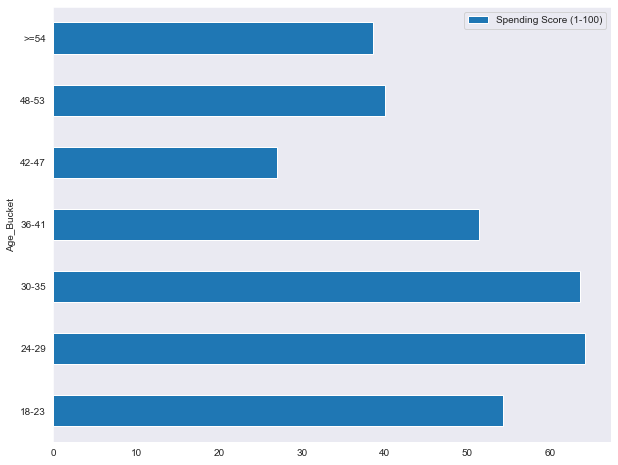

In [215]:
age_bucket.plot(kind="barh",x='Age_Bucket',y='Spending Score (1-100)',figsize=(10,8))

In [216]:
df.Age_Bucket.value_counts()

30-35    43
>=54     34
18-23    31
36-41    26
24-29    24
48-53    23
42-47    19
Name: Age_Bucket, dtype: int64

### Answer 2: We can see that customers witihin the Age group of 24-29 and 30-35 tend to have higher spending score than the rest of the Age groups.

## Question 3: What is the distribuation of Age group with both Genders based on the average of their spending score?

In [33]:
age_bucket_female=df[df['Gender']=='Female']
age_bucket_female=get_mean_sc(age_bucket_female,['Age_Bucket','Gender'],'Spending Score (1-100)') 

age_bucket_male=df[df['Gender']=='Male']
age_bucket_male=get_mean_sc(age_bucket_male,['Age_Bucket','Gender'],'Spending Score (1-100)') 

age_bucket_gender=pd.concat([age_bucket_male,age_bucket_female],join='inner',keys='Age_Bucket')
age_bucket_gender=age_bucket_gender.reset_index(drop=True)

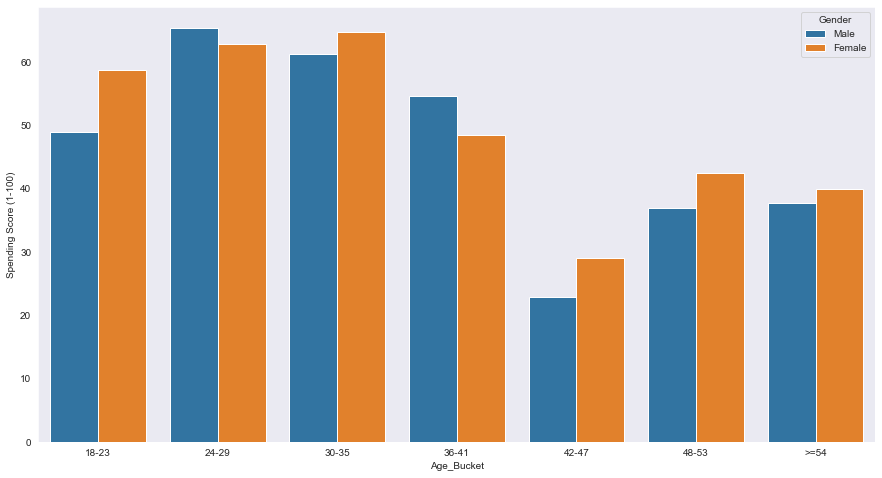

In [34]:
plt.figure(figsize=(15,8))
sns.barplot(data=age_bucket_gender,x='Age_Bucket',y='Spending Score (1-100)',hue='Gender')

### Answer 3: We can see that females tend to have higher spending score in almost all of the Age groups except 2.

# 4. Data modeling: 
    - I used Kmeans clustering algorithm to sperate our customers into segments to better target them.
    - I used the elbow method to get the best amount of cluster for our data.

In [219]:
k=range(1,12)
lis=[]
df_s=df[['Annual Income (k$)','Spending Score (1-100)']]
for i in k:
    kmeans=cluster.KMeans(n_clusters=i,init='k-means++')
    kmeans=kmeans.fit(df_s)
    iteration=kmeans.inertia_
    lis.append(iteration)

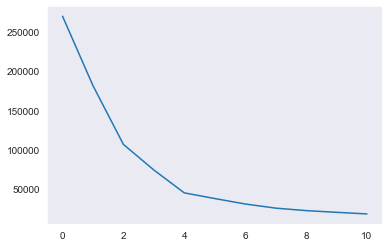

In [220]:
plt.plot(lis)

### We can find from the elbow method that the best amount of clusters is 5 clusters

In [221]:
kmeans=cluster.KMeans(n_clusters=5,init='k-means++')
df_s=df[['Annual Income (k$)','Spending Score (1-100)']]
kmeans=kmeans.fit(df_s)
df['clusters']=kmeans.labels_

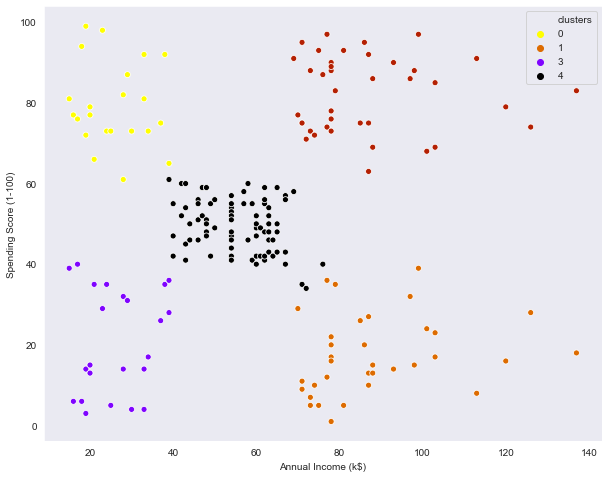

In [228]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='clusters',data=df, palette="gnuplot_r")

# 5. Results evaluation: 
    - When we divided the customers into 5 segments now we can know what are the best segments to target and what are the segments that we need to stay away from. Like we can spend good resources to target cluster 3 and increase their spending score.
    - We chose 5 clusters with the help of the elbow method this gave us the best amount of clusters.